In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
from torchvision.models import resnet50
from torch.autograd import Variable
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
import torchvision.transforms as transforms

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-5, 5)),  # Randomly rotate the image by up to 5 degrees clockwise or counterclockwise
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Adjust brightness, contrast, saturation, and hue with reduced magnitude
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),       # Random affine transformation with reduced magnitude
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
])

# No data augmentation for validation/test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [21]:
# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
class AdaptiveActivation(nn.Module):
    def __init__(self, in_features):
        super(AdaptiveActivation, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, 1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        weight = self.weight.expand_as(x)
        return self.sigmoid(weight) * F.relu(x) + (1 - self.sigmoid(weight)) * F.leaky_relu(x)

In [23]:
class CNN1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        #self.adaptive_activation1 = AdaptiveActivation(in_features=384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        #self.adaptive_activation2 = AdaptiveActivation(in_features=384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.adaptive_activation3 = AdaptiveActivation(in_features=256)
        self.fc1 = nn.Linear(in_features=256 * 12 * 12, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        #x = self.adaptive_activation1(x)
        x = F.relu(self.conv4(x))
        #x = self.adaptive_activation2(x)
        x = F.relu(self.conv5(x))
        #x = self.adaptive_activation3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [24]:
# Training loop
def train(epoch, net, trainloader, optimizer, criterion):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Calculate accuracy after each epoch
    accuracy = 100 * correct / total
    epoch_list.append(epoch + 1)  # Append epoch number to list
    accuracy_list.append(accuracy)  # Append accuracy to list
    print('Epoch [%d], Accuracy on training images: %d %%' % (epoch + 1, accuracy))

In [25]:
# Test the model
def test(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on test images: %d %%' % (100 * correct / total))


In [26]:
# Iniltialize the model
net = CNN1().to(device)
# Print the model architecture
#print(net)
#Initialize optimizer and Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
# Lists to store epoch and accuracy values
epoch_list = []
accuracy_list = []

# Train the model
for epoch in range(5):  # loop over the dataset multiple times
    train(epoch, net, trainloader, optimizer, criterion)

test(net, testloader)

Epoch [1], Accuracy on training images: 41 %
Epoch [2], Accuracy on training images: 54 %
Epoch [3], Accuracy on training images: 61 %
Epoch [4], Accuracy on training images: 66 %
Epoch [5], Accuracy on training images: 69 %
Accuracy on test images: 73 %


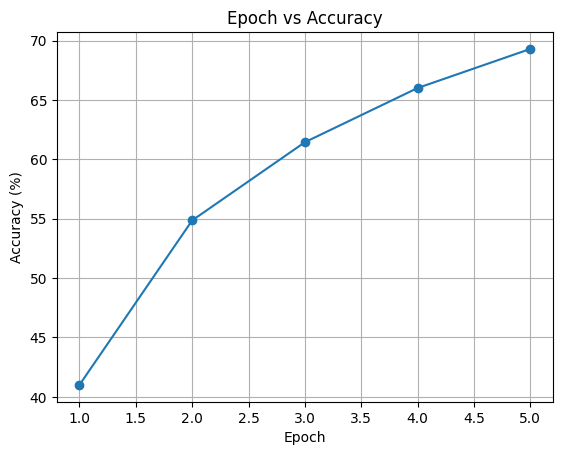

In [28]:
import matplotlib.pyplot as plt
# Plot epoch vs accuracy
plt.plot(epoch_list, accuracy_list, marker='o')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()